# ML Model to Predict Pump Station Failure

## Background and Motivation

A town's pump station has equipment that is failing. When equipment fails, the entire process comes to a halt and the failed equipment needs to be taken out of service and fixed before startup can begin. When the process unexpectedly fails, it takes longer for maintenance personnel to address the problem than if they proactively checked the equipment. 

Therefore, in order to minimize the overall process downtime, the maintenance supervisor would like to proactively address system issues before they bring down the entire pump station. 

Overall steps:
<ul>
    <li>Exploratory Data Analysis</li>
        <ul>
            <li>Sanitize and Prepare the Data for Modeling</li>
            <li>Perform Feature Engineering</li>
            <li>Analyze and Visualize for Machine Learning</li>
        </ul>
    <li>Modeling</li>
        <ul>
            <li>Model Selection</li>
            <li>Training</li>
            <li>Hyperparameter Optimization</li>
            <li>ML Model Evaluation</li>
        </ul>
</ul>

# Exploratory Data Analysis

## Sanitize and Prepare Data for Modeling

In [1]:
import pandas as pd
import numpy as np

file_path = 'sensor.csv'
df = pd.read_csv(file_path)

num_records = len(df)
column_names = df.columns.tolist()
non_blank_records = df.count()

In [2]:
# Number of records
print(f"Number of records: {num_records}\n")

# Number of non-blank records per feature
print("Number of non-blank records per feature:")
print(non_blank_records)

Number of records: 220320

Number of non-blank records per feature:
Unnamed: 0        220320
timestamp         220320
sensor_00         210112
sensor_01         219951
sensor_02         220301
sensor_03         220301
sensor_04         220301
sensor_05         220301
sensor_06         215522
sensor_07         214869
sensor_08         215213
sensor_09         215725
sensor_10         220301
sensor_11         220301
sensor_12         220301
sensor_13         220301
sensor_14         220299
sensor_15              0
sensor_16         220289
sensor_17         220274
sensor_18         220274
sensor_19         220304
sensor_20         220304
sensor_21         220304
sensor_22         220279
sensor_23         220304
sensor_24         220304
sensor_25         220284
sensor_26         220300
sensor_27         220304
sensor_28         220304
sensor_29         220248
sensor_30         220059
sensor_31         220304
sensor_32         220252
sensor_33         220304
sensor_34         220304
sensor_

The output above provides valuable information about the dataset. Here's a summary of the actions we will take:
<ul>
    <li>Drop the index column</li>
    <li>Decide how to handle missing values</li>
    <li>Decide how to handle the timestamp feature</li>
    <li>Drop sensor_15</li>
    <li>Convert machine status (the target) to binary</li>
    <li>Decide whether you want to standardize or nomalize the data</li>
    <li>Identify and handle outliers</li>
</ul>

### Drop index and empty columns

In [3]:
# Drop the index column
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('sensor_15', axis=1, inplace=True)

### Handling Missing Values

Most sensors have at least 95% non-blank values. For these, we will simply drop those records. 

The outlier is **sensor_50** which has 35% empty values. For this sensor, we will use linear regression (based on the values of the other sensor values) to predict the value of that sensor. 

## Imputing Missing Values of a Feature Using Machine Learning

### Remove the records with empty values

In [4]:
# Drop records with missing values for specified columns
df_cleaned = df.dropna()

# Display the number of records after cleaning
num_records_cleaned = len(df_cleaned)
print(f"Number of records remaining after dropping empties: {num_records_cleaned}")

Number of records remaining after dropping empties: 119103


### Remove records containing outliers

In [5]:
# We'll use standardization (Z-score normalization) since we are dealing with different units among the sensors.

from sklearn.preprocessing import StandardScaler

# All sensor columns
sensor_columns = [
    'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
    'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
    'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
    'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
    'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
    'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
    'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
    'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
    'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
    'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
    'sensor_51'
]

# Apply StandardScaler to sensor columns
scaler = StandardScaler()
df_cleaned.loc[:, sensor_columns] = scaler.fit_transform(df_cleaned[sensor_columns])

In [6]:
# Define a threshold for anomaly detection (you can adjust this based on your data and requirements)
anomaly_threshold = 6.0  # Standard deviation

# Create a condition for anomaly detection for each sensor column
anomaly_condition = (np.abs(df_cleaned[sensor_columns]) > anomaly_threshold).any(axis=1)

# Filter the DataFrame to exclude records with anomalies
df_no_anomalies = df_cleaned[~anomaly_condition]

In [7]:
# Display the number of records after cleaning
num_records_cleaned_without_anomalies = len(df_no_anomalies)
print(f"Number of records remaining after dropping anomalous rows: {num_records_cleaned_without_anomalies}")

Number of records remaining after dropping anomalous rows: 114270


### Convert timestamps to features

In [8]:
# Convert timestamp to datetime
df_cleaned = df_cleaned.copy()
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# Extract relevant features
df_cleaned['month'] = df_cleaned['timestamp'].dt.month
df_cleaned['day'] = df_cleaned['timestamp'].dt.day
df_cleaned['hour'] = df_cleaned['timestamp'].dt.hour

# Drop the original timestamp column
df_cleaned = df_cleaned.drop('timestamp', axis=1)

### One-Hot Encode Equipment Status

In [9]:
# One-hot encode the 'machine_status' column
df_cleaned = pd.get_dummies(df_cleaned, columns=['machine_status'])

# Convert boolean columns to 0 or 1
df_cleaned[['machine_status_BROKEN', 'machine_status_NORMAL', 'machine_status_RECOVERING']] = df_cleaned[
    ['machine_status_BROKEN', 'machine_status_NORMAL', 'machine_status_RECOVERING']
].astype(int)

In [10]:
df_cleaned.head(5)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_48,sensor_49,sensor_50,sensor_51,month,day,hour,machine_status_BROKEN,machine_status_NORMAL,machine_status_RECOVERING
0,0.259048,-0.382813,0.564777,1.368915,0.236304,0.091666,0.116406,0.178085,0.247757,0.123432,...,0.680734,1.117312,0.877594,0.068121,4,1,0,0,1,0
1,0.259048,-0.382813,0.564777,1.368915,0.236304,0.091666,0.116406,0.178085,0.247757,0.123432,...,0.680734,1.117312,0.877594,0.068121,4,1,0,0,1,0
2,0.213126,-0.271927,0.564777,1.413718,0.288637,-0.106438,0.064085,0.123865,0.278121,0.097288,...,0.644853,1.070892,0.843991,0.097974,4,1,0,0,1,0
3,0.248112,-0.382813,0.549809,1.413717,0.163843,0.127648,0.059728,0.244829,0.325830,0.140865,...,0.644853,1.047683,0.827191,0.090511,4,1,0,0,1,0
4,0.215313,-0.364333,0.564777,1.413717,0.260457,0.100451,0.081528,0.223972,0.325830,0.140865,...,0.685861,1.024473,0.860792,0.068121,4,1,0,0,1,0


We now have our training data set and can begin training our ML models.

### Train a Linear Regression Model

In [11]:
# Features (exclude sensor_50)
X = df_cleaned.drop('sensor_50', axis=1)

# Target variable
y = df_cleaned['sensor_50']

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [13]:
# Predict missing values
predicted_sensor_50 = model.predict(X)

In [14]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

### Linear Regression Model Results

In [15]:
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.2567832955204819
Mean Absolute Error: 0.3104726397594721
R-squared: 0.7470109677608439


### Train, Test, and Evaluate a Decision Tree Model

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Decision Tree model
tree_model = DecisionTreeRegressor(
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features=None, 
    criterion='squared_error',
    random_state=42
)

tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = tree_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.07804880037336323
Mean Absolute Error: 0.12731324936886446
R-squared: 0.9231044588244671


### Train, Test, and Evaluate a Random Forest Model

In [17]:
from sklearn.ensemble import RandomForestRegressor

# Create the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100, # Higher is more complex
    random_state=42, 
    max_depth=20, # Higher is more complex
    min_samples_split=5, # Higher is less complex
    min_samples_leaf=5, # Higher is less complex
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Mean Squared Error (Random Forest): {mse_rf}')
print(f'Mean Absolute Error (Random Forest): {mae_rf}')
print(f'R-squared (Random Forest): {r2_rf}')

Mean Squared Error (Random Forest): 0.047694352771813706
Mean Absolute Error (Random Forest): 0.12747594143060556
R-squared (Random Forest): 0.9530103851710571


In [18]:
print(X_train.columns)

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_51',
       'month', 'day', 'hour', 'machine_status_BROKEN',
       'machine_status_NORMAL', 'machine_status_RECOVERING'],
      dtype='object')


We could continue to optimize the Random Forest Model, but this is good enough for now. 

### Use the Random Forest Model to Impute 'sensor_50'

In [19]:
print(df.columns)

Index(['timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')


For all columns except 'sensor_50', drop records that are missing a value.

In [20]:
columns_to_check = ['timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_51', 'machine_status']

df_cleaned = df.dropna(subset=columns_to_check)
df_cleaned.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [21]:
print(len(df_cleaned))

195815


### Remove Outliers

In [22]:
# We'll use standardization (Z-score normalization) since we are dealing with different units among the sensors.

from sklearn.preprocessing import StandardScaler

# All sensor columns
sensor_columns = [
    'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
    'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
    'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
    'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
    'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
    'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
    'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
    'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
    'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
    'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
    'sensor_51'
]

# Apply StandardScaler to sensor columns
scaler = StandardScaler()
df_cleaned.loc[:, sensor_columns] = scaler.fit_transform(df_cleaned[sensor_columns])

# Define a threshold for anomaly detection (you can adjust this based on your data and requirements)
anomaly_threshold = 6  # Standard deviation

# Create a condition for anomaly detection for each sensor column
anomaly_condition = (np.abs(df_cleaned[sensor_columns]) > anomaly_threshold).any(axis=1)

# Filter the DataFrame to exclude records with anomalies
df_no_anomalies = df_cleaned[~anomaly_condition]

# Display the number of records after cleaning
num_records_cleaned_without_anomalies = len(df_no_anomalies)
print(f"Number of records remaining after dropping anomalous rows: {num_records_cleaned_without_anomalies}")

Number of records remaining after dropping anomalous rows: 187579


In [23]:
empty_values_count = df_no_anomalies['sensor_50'].isna().sum()

print(f"Number of empty values in 'sensor_50': {empty_values_count}")

Number of empty values in 'sensor_50': 74329


### Handling Timestamps and One-Hot Encoding

In [24]:
# Convert timestamp to datetime
df_cleaned = df_no_anomalies.copy()
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# Extract relevant features
df_cleaned['month'] = df_cleaned['timestamp'].dt.month
df_cleaned['day'] = df_cleaned['timestamp'].dt.day
df_cleaned['hour'] = df_cleaned['timestamp'].dt.hour

# Drop the original timestamp column
df_cleaned = df_cleaned.drop('timestamp', axis=1)

# One-hot encode the 'machine_status' column
df_cleaned = pd.get_dummies(df_cleaned, columns=['machine_status'])

# Convert boolean columns to 0 or 1
df_cleaned[['machine_status_BROKEN', 'machine_status_NORMAL', 'machine_status_RECOVERING']] = df_cleaned[
    ['machine_status_BROKEN', 'machine_status_NORMAL', 'machine_status_RECOVERING']
].astype(int)

In [25]:
empty_values_count = df_cleaned['sensor_50'].isna().sum()

print(f"Number of empty values in 'sensor_50': {empty_values_count}")

Number of empty values in 'sensor_50': 74329


### Making Prediction for 'sensor_50' using our Random Forest Model

In [26]:
#X_new_data = df_cleaned.loc[index, X_train.columns].to_frame().T
#print(X_new_data.columns)

In [27]:
df_missing = df_cleaned[df_cleaned['sensor_50'].isnull()]
df_not_missing = df_cleaned.dropna(subset=['sensor_50'])

print(len(df_missing))
print(len(df_not_missing))

74329
113250


In [28]:
X_pred = df_missing.drop(['sensor_50'], axis=1)
print(len(X_pred))

74329


In [29]:
predicted_values = rf_model.predict(X_pred)
print(predicted_values)
print(len(predicted_values))

[0.33485475 0.11928357 0.23609146 ... 2.07734692 2.79137024 2.6102224 ]
74329


In [30]:
df_cleaned.loc[df_cleaned['sensor_50'].isnull(), 'sensor_50'] = predicted_values

In [31]:
df_cleaned.head(50)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_48,sensor_49,sensor_50,sensor_51,month,day,hour,machine_status_BROKEN,machine_status_NORMAL,machine_status_RECOVERING
0,0.198619,-0.393125,0.689953,1.215624,0.188027,0.215289,-0.230898,0.038192,0.128305,0.036109,...,-0.037958,0.476808,0.877594,0.046574,4,1,0,0,1,0
1,0.198619,-0.393125,0.689953,1.215624,0.188027,0.215289,-0.230898,0.038192,0.128305,0.036109,...,-0.037958,0.476808,0.877594,0.046574,4,1,0,0,1,0
2,0.143029,-0.287478,0.689953,1.264757,0.250592,-0.018753,-0.288901,-0.028216,0.165169,0.004051,...,-0.063258,0.446065,0.843991,0.082202,4,1,0,0,1,0
3,0.185380,-0.393125,0.671998,1.264756,0.101399,0.257798,-0.293732,0.119939,0.223093,0.057486,...,-0.063258,0.430694,0.827191,0.073295,4,1,0,0,1,0
4,0.145677,-0.375518,0.689953,1.264756,0.216903,0.225668,-0.269565,0.094394,0.223093,0.057486,...,-0.034343,0.415322,0.860792,0.046574,4,1,0,0,1,0
5,0.166852,-0.393125,0.671998,1.264756,0.232945,0.353920,-0.230898,0.063736,0.365271,0.116263,...,0.045167,0.415322,0.849592,0.051027,4,1,0,0,1,0
6,0.172148,-0.410731,0.671998,1.264756,0.173589,0.163592,-0.216399,0.038192,0.191492,0.057486,...,0.135521,0.476808,0.821590,0.028760,4,1,0,0,1,0
7,0.156265,-0.375518,0.671998,1.264756,0.136692,0.160152,-0.337236,0.033086,0.586441,0.057486,...,0.218647,0.522923,0.843991,0.042120,4,1,0,0,1,0
8,0.193323,-0.393125,0.671998,1.264756,0.154338,0.065038,-0.313069,0.038192,0.059847,0.084197,...,0.262016,0.569037,0.877594,0.051027,4,1,0,0,1,0
9,0.145677,-0.357908,0.671998,1.264756,0.290696,0.063843,-0.250235,0.119939,0.165169,0.084197,...,0.319842,0.584409,0.944796,0.037667,4,1,0,0,1,0


In [32]:
df_cleaned.tail(50)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_48,sensor_49,sensor_50,sensor_51,month,day,hour,machine_status_BROKEN,machine_status_NORMAL,machine_status_RECOVERING
220263,0.021263,-0.111403,-0.423331,-0.675885,0.378930,-0.567901,0.933935,0.344720,0.101974,0.036109,...,0.955933,5.887597,3.324673,0.696787,8,31,23,0,1,0
220264,0.034499,-0.111403,-0.423332,-0.675885,0.143109,-0.540253,0.909768,0.375378,0.165169,0.004051,...,1.006531,5.949083,3.350366,0.692333,8,31,23,0,1,0
220268,0.023911,-0.093795,-0.405373,-0.651322,0.224924,-0.297587,0.890438,0.406029,0.365271,0.057486,...,1.357103,5.887597,1.955162,0.687881,8,31,23,0,1,0
220273,0.026558,-0.093795,-0.405374,-0.651322,0.146317,-0.379380,0.933935,0.406029,0.165169,0.116263,...,1.725746,5.826111,1.690133,0.647798,8,31,23,0,1,0
220274,0.023911,-0.093795,-0.405374,-0.651322,0.168776,-0.278157,0.861440,0.477550,0.101974,0.084197,...,1.725746,5.426448,1.684973,0.670065,8,31,23,0,1,0
220275,0.029206,-0.093795,-0.405373,-0.651322,0.130275,-0.249902,0.987108,0.406029,0.191492,0.084197,...,1.725746,4.980673,1.718430,0.687881,8,31,23,0,1,0
220276,0.023911,-0.093795,-0.423332,-0.626758,0.086962,-0.226320,0.861440,0.344720,0.191492,0.148321,...,1.729361,4.673244,1.633092,0.696787,8,31,23,0,1,0
220277,0.042441,-0.093795,-0.423332,-0.626756,0.167172,-0.156901,0.890438,0.441793,0.223093,0.057486,...,1.725746,4.365815,1.655758,0.670065,8,31,23,0,1,0
220278,0.029206,-0.093795,-0.405373,-0.626756,0.171985,-0.195362,0.890438,0.406029,0.249423,0.084197,...,1.689605,4.027637,1.703860,0.580995,8,31,23,0,1,0
220279,0.034499,-0.093795,-0.423332,-0.626756,0.305136,-0.059954,0.933935,0.441793,0.165169,0.084197,...,1.664305,3.643348,1.762691,0.554274,8,31,23,0,1,0


In [33]:
print(len(df_cleaned))

187579


Note that this matches the number of records before imputation!

We now have a complete dataset with anomalous data removed, timestamps converted to features, targets converted to binary values using one-hot encoding, and (most importantly) successfully imputed values for **sensor_50** using the Random Forest ensemble learning method. 

Once we begin predicting pump station shutdowns, we'll need to compare how well this imputation method works vs. other methods such as taking the mean, mode, or just dropping those records.

## Data Visualization for Machine Learning

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_importances = rf_model.feature_importances_

# Create a DataFrame to visualize feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

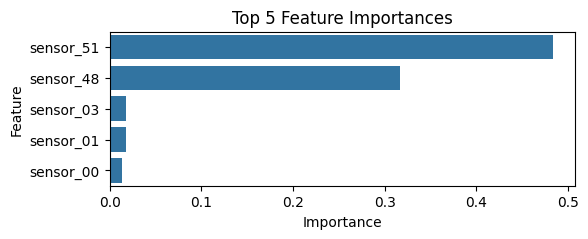

In [35]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_10_features = feature_importance_df.head(5)

# Plot feature importances for the top 10 features
plt.figure(figsize=(6, 2))
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top 5 Feature Importances')
plt.show()

### Calculate the frequency of 'broken' events

In [36]:
df_date = df_cleaned
df_date['date'] = pd.to_datetime(df_date[['month', 'day']].assign(year=2018))

# Calculate the time span
min_date = df_date['date'].min()
max_date = df_date['date'].max()
time_span = max_date - min_date

# Display the time span
print(f'Total Time Span: {time_span.days} days')

Total Time Span: 152 days


In [37]:
# Assuming df is your DataFrame
num_broken_events = df_date['machine_status_BROKEN'].sum()

print(f'Number of BROKEN events: {num_broken_events}')

Number of BROKEN events: 3


In [38]:
df_date['is_broken'] = df_date['machine_status_BROKEN'] == 1
df_date['break_point'] = (df_date['is_broken'] != df_date['is_broken'].shift(1)).astype(int)

# Extract the dates corresponding to 'BROKEN' events
broken_dates = df_date.loc[df_date['is_broken'], 'date']

# Calculate the number of days between consecutive 'BROKEN' events
days_between_events = broken_dates.diff().dt.days

# Display the result
print(days_between_events)

24510      NaN
69318     31.0
166440    67.0
Name: date, dtype: float64


Within our cleaned dataset, the total timespan is about 5 months. Over these 5 months, there are 3 equipment malfunction events that occurred. 

The time between the first and second event is about a month, and the time between the second and third event is 2.5 months. 

### Add a label as an anticipation window

In [39]:
# Assuming df is your DataFrame
df_cleaned = df_cleaned[df_cleaned['machine_status_RECOVERING'] != 1]

# Reset index if needed
df_cleaned = df_cleaned.reset_index(drop=True)

print(len(df_cleaned))
print(df_cleaned.columns)

187526
Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51', 'month', 'day', 'hour', 'machine_status_BROKEN',
       'machine_status_NORMAL', 'machine_status_RECOVERING', 'date',
       'is_broken', 'break_point'],
      dtype='object')


In [40]:
from datetime import datetime, timedelta

anticipation_window_duration = timedelta(hours=3)

# Convert 'month', 'day', and 'hour' to a pseudo-timestamp
df_cleaned['pseudo_timestamp'] = df_cleaned.apply(lambda row: datetime(2018, int(row['month']), int(row['day']), int(row['hour'])), axis=1)

# Create a new column for the anticipation label
df_cleaned['anticipation_label'] = 'not_anticipating'  # Default label

# Iterate through the dataset
for index, row in df_cleaned.iterrows():
    if row['machine_status_BROKEN'] == 1:  # Check if it's a malfunction event
        anticipation_start_time = row['pseudo_timestamp'] - anticipation_window_duration
        anticipation_mask = (
            (df_cleaned['pseudo_timestamp'] > anticipation_start_time)
            & (df_cleaned['pseudo_timestamp'] <= row['pseudo_timestamp'])
        )
        df_cleaned.loc[anticipation_mask, 'anticipation_label'] = 'anticipating'

# Drop the pseudo-timestamp column if you don't need it anymore
df_cleaned = df_cleaned.drop('pseudo_timestamp', axis=1)

In [41]:
anticipating_count = len(df_cleaned[df_cleaned['anticipation_label'] == 'anticipating'])
print(f'Total number of records labeled as "anticipating": {anticipating_count}')

Total number of records labeled as "anticipating": 405


### Drop extra columns and prepare for ML models

In [42]:
print(df_cleaned.columns)

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51', 'month', 'day', 'hour', 'machine_status_BROKEN',
       'machine_status_NORMAL', 'machine_status_RECOVERING', 'date',
       'is_broken', 'break_point', 'anticipation_label'],
      dtype='object')


In [43]:
# Drop columns
columns_to_drop = ['machine_status_RECOVERING', 'machine_status_BROKEN', 'date', 'is_broken', 'break_point']
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

# Convert anticipation_label to binary
df_cleaned['anticipation_label'] = (df_cleaned['anticipation_label'] == 'anticipating').astype(int)
print(df_cleaned.columns)

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51', 'month', 'day', 'hour', 'machine_status_NORMAL',
       'anticipation_label'],
      dtype='object')


In [44]:
unique_values = df_cleaned['anticipation_label'].unique()

# Print unique values
print("Unique Values:")
print(unique_values)

# Get counts of each unique value
value_counts = df_cleaned['anticipation_label'].value_counts()

# Print counts
print("\nValue Counts:")
print(value_counts)

Unique Values:
[0 1]

Value Counts:
anticipation_label
0    187121
1       405
Name: count, dtype: int64


### Splitting the data to form train, test, and validation sets

In [48]:
X = df_cleaned.drop(['machine_status_NORMAL', 'anticipation_label'], axis=1)
y = df_cleaned[['anticipation_label']]

# Split the data into training and temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) # 30% for testing and validation

# Further split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.66, random_state=42)

# Print the shapes of the resulting sets
print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Validation set:", X_val.shape, y_val.shape)

Training set: (131268, 54) (131268, 1)
Validation set: (19127, 54) (19127, 1)
Test set: (37131, 54) (37131, 1)


### Use SMOTE to generate additional samples of the minority class in the test data set

In [50]:
from imblearn.over_sampling import SMOTE

# Count the occurrences of each class
class_counts = y_train.value_counts()

desired_ratio_factor = 0.05

# Calculate the desired ratio for SMOTE
desired_ratio = {0: class_counts[0], 1: int(class_counts[0] * desired_ratio_factor)}

# Apply SMOTE only to the minority class (anticipation_label = 1)
smote = SMOTE(sampling_strategy=desired_ratio, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Original Training set:", X_train.shape, y_train.shape)
print("SMOTE Training set:", X_resampled.shape, y_resampled.shape)

Original Training set: (131268, 54) (131268, 1)
SMOTE Training set: (137522, 54) (137522, 1)


In [52]:
# Count the occurrences of each class in y_resampled
resampled_class_counts = y_resampled.iloc[:, 0].value_counts()

# Print the counts
print(resampled_class_counts)

anticipation_label
0    130974
1      6548
Name: count, dtype: int64


## ML Training and Testing

### Decision Tree Model

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model on the resampled training data
dt_classifier.fit(X_resampled, y_resampled)

# Make predictions on the validation set
y_test_pred = dt_classifier.predict(X_test)

In [58]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_test_pred)
classification_report_str = classification_report(y_test, y_test_pred)

# Print the results
print(f"Accuracy on Test Set: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report_str)

Accuracy on Validation Set: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     37080
           1       0.89      0.92      0.90        51

    accuracy                           1.00     37131
   macro avg       0.94      0.96      0.95     37131
weighted avg       1.00      1.00      1.00     37131



### XGBoost (Gradient Boosting) Model

In [60]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Convert your data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'error',  # Error rate for evaluation
    'max_depth': 3,  # Maximum depth of a tree
    'eta': 0.1,  # Learning rate
    'seed': 42
}

# Train the XGBoost model
num_rounds = 100  # You can adjust this based on your data and performance
xg_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred = xg_model.predict(dtest)
y_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_pred]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
class_report = classification_report(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Accuracy: 0.9999730683256578
Confusion Matrix:
 [[37080     0]
 [    1    50]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     37080
           1       1.00      0.98      0.99        51

    accuracy                           1.00     37131
   macro avg       1.00      0.99      1.00     37131
weighted avg       1.00      1.00      1.00     37131



### Neural Network with TensorFlow

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification, so 'sigmoid' activation

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set
y_pred_prob = model.predict(X_test)
y_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_pred_prob]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
class_report = classification_report(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Epoch 1/100
4103/4103 [==============================] - 7s 2ms/step - loss: 0.0083 - accuracy: 0.9979 - val_loss: 0.0047 - val_accuracy: 0.9977
Epoch 2/100
4103/4103 [==============================] - 6s 2ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.0021 - val_accuracy: 0.9993
Epoch 3/100
4103/4103 [==============================] - 6s 2ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0014 - val_accuracy: 0.9996
Epoch 4/100
4103/4103 [==============================] - 7s 2ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0011 - val_accuracy: 0.9994
Epoch 5/100
4103/4103 [==============================] - 8s 2ms/step - loss: 9.1293e-04 - accuracy: 0.9997 - val_loss: 9.0838e-04 - val_accuracy: 0.9996
Epoch 6/100
4103/4103 [==============================] - 7s 2ms/step - loss: 7.7999e-04 - accuracy: 0.9997 - val_loss: 0.0014 - val_accuracy: 0.9994
Epoch 7/100
4103/4103 [==============================] - 7s 2ms/step - loss: 8.5597e-04 - accuracy: 0.9997 - val_loss:

## Conclusions

The XGBoost model has the best recall of the 3 models we evaluated (98%). A recall of 98% means that out of all the records labeled as positive, only 2% were wrongly labeled as negative (not indicitive of an equipment malfunction event). 

### Adjusting the XGBoost threshold to boost recall

In [69]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Convert your data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',  # Logarithmic loss for evaluation
    'max_depth': 3,  # Maximum depth of a tree
    'eta': 0.1,  # Learning rate
    'seed': 42
}

# Train the XGBoost model
num_rounds = 100  # You can adjust this based on your data and performance
xg_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred_prob = xg_model.predict(dtest)
threshold = 0.20  # Adjust the threshold as needed
y_pred_binary = [1 if prob >= threshold else 0 for prob in y_pred_prob]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
class_report = classification_report(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.9998114782796046
Confusion Matrix:
 [[37073     7]
 [    0    51]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     37080
           1       0.88      1.00      0.94        51

    accuracy                           1.00     37131
   macro avg       0.94      1.00      0.97     37131
weighted avg       1.00      1.00      1.00     37131



With this new model, we correctly identified all instances of an equipment malfunction event. We do this at the expenses of incorrectly labeling 7 instances as incidicitive of an equipment malfunction event. 